In [12]:
import pandas as pd
import os, re
import json
# import ast
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns

In [13]:
os.listdir("./tempdir")

['Annual turnover from organisation benchmarking source data, March 2023.csv',
 'inactive_organisations.txt',
 'Monthly turnover from organisation benchmarking source data, March 2023.csv',
 'turnover.zip']

In [14]:
annual_csv = [f for f in os.listdir('./tempdir') if re.match(r"(?i)^annual", f)]
monthly_csv = [f for f in os.listdir('./tempdir') if re.match(r"(?i)^monthly", f)]

In [15]:
annual_csv

['Annual turnover from organisation benchmarking source data, March 2023.csv']

In [16]:
monthly_csv

['Monthly turnover from organisation benchmarking source data, March 2023.csv']

In [17]:
annual_df = pd.read_csv(f"./tempdir/{annual_csv[0]}")
monthly_df = pd.read_csv(f"./tempdir/{monthly_csv[0]}")

In [18]:
annual_df.head()

,Period,Type,Org code,Org name,NHSE region code,NHSE region name,ICS code,ICS name,Cluster group,Benchmark group,Staff group,HC,FTE
0,31/01/2022,Denoms,00Q,NHS Blackburn with Darwen CCG,Y62,North West,QE1,Lancashire and South Cumbria,Clinical Commissioning Group,Clinical Commissioning Group,Nurses & health visitors,4,3.10000
1,31/01/2022,Denoms,00Q,NHS Blackburn with Darwen CCG,Y62,North West,QE1,Lancashire and South Cumbria,Clinical Commissioning Group,Clinical Commissioning Group,"Scientific, therapeutic & technical staff",6,5.33334
2,31/01/2022,Denoms,00Q,NHS Blackburn with Darwen CCG,Y62,North West,QE1,Lancashire and South Cumbria,Clinical Commissioning Group,Clinical Commissioning Group,Senior managers,11,7.07254
3,31/01/2022,Denoms,00R,NHS Blackpool CCG,Y62,North West,QE1,Lancashire and South Cumbria,Clinical Commissioning Group,Clinical Commissioning Group,Managers,24,22.18000
4,31/01/2022,Denoms,00T,NHS Bolton CCG,Y62,North West,QOP,Greater Manchester,Clinical Commissioning Group,Clinical Commissioning Group,Nurses & health visitors,16,14.55333


In [19]:
monthly_df.head()

,Period,Type,Org code,Org name,NHSE region code,NHSE region name,ICS code,ICS name,Cluster group,Benchmark group,Staff group,HC,FTE
0,202112 to 202201,Leavers,RXX,Surrey and Borders Partnership NHS Foundation ...,Y59,South East,QXU,Surrey Heartlands,Mental Health,Mental Health and Learning Disability,All staff groups,46,41.09334
1,202112 to 202201,Leavers,RJ2,Lewisham and Greenwich NHS Trust,Y56,London,QKK,South East London,Acute,Acute - Large,All staff groups,112,101.00739
2,202112 to 202201,Leavers,RDR,Sussex Community NHS Foundation Trust,Y59,South East,QNX,Sussex,Community Provider Trust,Community Provider Trust,All staff groups,86,67.40329
3,202112 to 202201,Leavers,26A,NHS Norfolk and Waveney CCG,Y61,East of England,QMM,Norfolk and Waveney,Clinical Commissioning Group,Clinical Commissioning Group,All staff groups,9,8.20000
4,202112 to 202201,Leavers,RWX,Berkshire Healthcare NHS Foundation Trust,Y59,South East,QNQ,Frimley,Mental Health,Mental Health and Learning Disability,All staff groups,73,60.87147


Inactive organisations load

In [20]:
inactive_orgs = pd.read_json('./tempdir/inactive_organisations.txt')


In [21]:
def process_turnover_df(df, inactive_orgs):
    df1 = pd.DataFrame(df)
    
    # df1['date_string'] = df1['Period'].apply(lambda x: x.split(' to ')[-1]+'01' if x.endswith(('Leavers', 'Joiners')) else ('01/'+x[3:10] if x.startswith('Denoms') else None))
    #df1['thedate'] = pd.to_datetime(datetime.now())

    #changed so that the leavers and joiners date is the "to" date, rather than the "from" date:
    df1['thedate'] = df1.apply(lambda x: datetime.strptime(x['Period'].split(' to ')[1]+'01', '%Y%m%d') 
                               if x['Type'] in ('Leavers', 'Joiners') else (datetime.strptime('01/'+x['Period'][3:10], '%d/%m/%Y') 
                                                                            if x['Type'] == 'Denoms' else None), axis = 1) 
    
    df2 = df1.groupby(['Org code','NHSE region name','Benchmark group', 'Staff group', 'thedate']).apply(lambda x: 
        pd.Series({
        'n': x.shape[0],
        'join_HC': x.loc[x['Type'].str.contains('Joiners'), 'HC'].values[0] if any(x['Type'] == 'Joiners') else None,
        'join_FTE': x.loc[x['Type'] == 'Joiners', 'FTE'].values[0] if any(x['Type'] == 'Joiners') else None,
        'leave_HC': x.loc[x['Type'] == 'Leavers', 'HC'].values[0] if any(x['Type'] == 'Leavers') else None,
        'leave_FTE': x.loc[x['Type'] == 'Leavers', 'FTE'].values[0] if any(x['Type'] == 'Leavers') else None,
        'denom_HC': x.loc[x['Type'] == 'Denoms', 'HC'].values[0] if any(x['Type'] == 'Denoms') else None,
        'denom_FTE': x.loc[x['Type'] == 'Denoms', 'FTE'].values[0] if any(x['Type'] == 'Denoms') else None,
    })).reset_index().rename(columns={
        'Org code': 'org_code',
        'Staff group': 'staff_group',
        'thedate': 'month_year',
        'NHSE region name':'region_name',
        'Benchmark group':'org_type'
    }).drop_duplicates()

    # Drop CCGs and ICBs
    df3 = df2[~df2['org_type'].isin(['Clinical Commissioning Group','Integrated Care Board'])]

    # Merge inactive dataframe
    df4 = pd.merge(df3, inactive_orgs, on='org_code', how='left')

    # Filter out inactive organizations
    df4 = df4[~df4['name'].notna()].copy()
    df4.drop(columns='name', inplace=True)

    return df4


In [22]:
# ~ 10 min runtime
processed_annual_df = process_turnover_df(annual_df, inactive_orgs) 
processed_annual_df.shape[0]

181008

In [23]:
processed_annual_df.head()


,org_code,region_name,org_type,staff_group,month_year,n,join_HC,join_FTE,leave_HC,leave_FTE,denom_HC,denom_FTE
0,R0A,North West,Acute - Teaching,All staff groups,2017-10-01,1.0,NaN,NaN,NaN,NaN,19130.0,17095.95832
1,R0A,North West,Acute - Teaching,All staff groups,2017-11-01,1.0,NaN,NaN,NaN,NaN,19211.0,17171.25859
2,R0A,North West,Acute - Teaching,All staff groups,2017-12-01,1.0,NaN,NaN,NaN,NaN,19214.0,17170.86679
3,R0A,North West,Acute - Teaching,All staff groups,2018-01-01,1.0,NaN,NaN,NaN,NaN,19295.0,17240.69400
4,R0A,North West,Acute - Teaching,All staff groups,2018-02-01,1.0,NaN,NaN,NaN,NaN,19326.0,17271.63829


In [24]:
# Look at one organisation to check data
processed_annual_df.loc[processed_annual_df['org_code'] == 'R0A'].sort_values(by=['n', 'month_year'], ascending=False).head()

,org_code,region_name,org_type,staff_group,month_year,n,join_HC,join_FTE,leave_HC,leave_FTE,denom_HC,denom_FTE
65,R0A,North West,Acute - Teaching,All staff groups,2023-03-01,3.0,4196.0,3931.47910,3570.0,3151.02126,27457.0,24800.67919
169,R0A,North West,Acute - Teaching,Central functions,2023-03-01,3.0,411.0,389.09189,408.0,381.38077,2540.0,2356.71260
235,R0A,North West,Acute - Teaching,HCHS doctors (exc. junior Drs),2023-03-01,3.0,138.0,109.50811,133.0,108.40969,1710.0,1559.80996
301,R0A,North West,Acute - Teaching,"Hotel, property & estates",2023-03-01,3.0,138.0,118.37331,91.0,75.33602,873.0,749.60139
367,R0A,North West,Acute - Teaching,Managers,2023-03-01,3.0,32.0,31.40000,24.0,23.58666,337.0,327.82668


In [25]:
#processed_annual_df['month_year'].unique()

In [26]:
# ~10mins runtime (2m on M1 iMac)
processed_monthly_df = process_turnover_df(monthly_df,inactive_orgs) 
processed_monthly_df.shape[0]

147107

In [39]:
# clip start and end for test dataframe (done in data processing file for final dataframe)
start_date = pd.to_datetime('2019-04-01')
end_date = pd.to_datetime('2023-07-01')

# test dataframe aggregated up to national level
test = processed_annual_df.groupby(['month_year','staff_group','org_code']).agg({'leave_FTE':'sum','denom_FTE':'sum'}).reset_index()

# leaver rate column
test['rate'] = test['leave_FTE']/test['denom_FTE']

# one staff group for test
test_staff_group = 'Nurses & health visitors'
test_sg =  test[test['staff_group'] == test_staff_group]

test_sg['month_year'] = pd.to_datetime(test_sg['month_year'])

test_sg = test_sg[(test_sg['month_year'] >= start_date) & (test_sg['month_year'] <= end_date)]

C:\Users\MarieRogers\AppData\Local\Temp\ipykernel_9712\2846070656.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_sg['month_year'] = pd.to_datetime(test_sg['month_year'])


In [31]:
# org_sg = processed_annual_df.groupby(['month_year','staff_group','org_code']).agg({'leave_FTE':'sum','denom_FTE':'sum'}).reset_index()
# org_sg['month_year'] = pd.to_datetime(org_sg['month_year'])

# org_sg = org_sg[(org_sg['month_year'] >= start_date) & (org_sg['month_year'] <= end_date)]

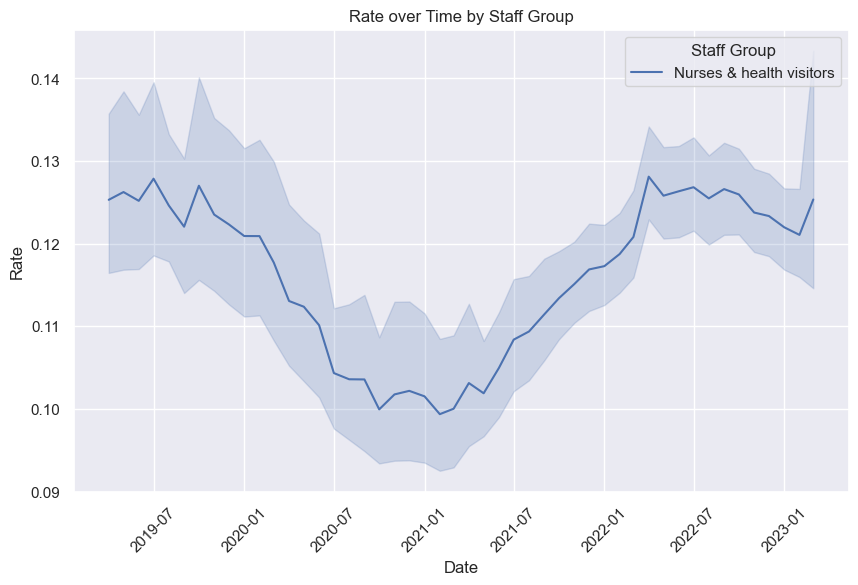

In [40]:
sns.set()

plt.figure(figsize=(10, 6))  
sns.lineplot(data=test_sg, x='month_year', y='rate', hue='staff_group')
plt.xlabel('Date')
plt.ylabel('Rate')
plt.title('Rate over Time by Staff Group')
plt.legend(title='Staff Group', loc='best')  
plt.xticks(rotation=45)  
plt.show()

In [ ]:
processed_annual_df.to_csv('../processed_annual_turnover.csv', index=False)
#processed_monthly_df.to_csv('./tempdir/processed_monthly_data.csv', index=False)

In [ ]:
processed_monthly_df.to_csv('../processed_monthly_turnover.csv', index=False)

In [ ]:
inactive_orgs.to_csv('../inactive_orgs.csv')